In [5]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [6]:
import tensorflow

In [7]:
data = pd.read_csv('Material/fer2013/fer2013.csv')
data.tail()

,emotion,pixels,Usage
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest


In [8]:
pixels = data['pixels'].tolist()

In [ ]:
largura, altura = 48, 48
faces = []
amostras = 0

for pixel_sequence in pixels:
    face = [int(pixel) for pixel in pixel_sequence.split(' ')]
    face = np.asarray(face).reshape(largura, altura)
    faces.append(face)

In [13]:
faces = np.asarray(faces)
faces = np.expand_dims(faces, -1)
faces.shape


(35887, 48, 48, 1)

In [14]:
def normalizar(x):
    x = x.astype('float32')
    x = x / 255.0 # transforma pra float e normaliza
    return x

In [15]:
faces = normalizar(faces)

In [16]:
emocoes = pd.get_dummies(data['emotion']).values

In [17]:
# imports do tensorflow
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json

In [18]:
x_train, x_test, y_train, y_test = train_test_split(faces, emocoes, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=41) # pula o primeiro e terceiro parametro

In [19]:
np.save('mod_xtest', x_test)
np.save('mod_ytest', y_test)

In [21]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 2
width, height = 48, 48

# define o modelo
model = Sequential()

# passa as camadas pro modelo
model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu',
                 input_shape=(width, height, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same')) # nao perde a coluna do padding
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

# flatten
model.add(Flatten())

# camada densa
model.add(Dense(num_features, activation='relu'))
model.add(Dropout(0.5))

# saida
model.add(Dense(num_labels, activation='softmax'))

# summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 46, 64)        640       
                                                                 
 conv2d_5 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization_3 (Batc  (None, 46, 46, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 23, 23, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 23, 23, 128)      

In [22]:
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

arquivo_modelo = 'modelo_01_pratica_expressosses.h5'
arquivo_modelo_json = 'modelo_01_pratica_expressosses.json'

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto') # para o treinamento se nao houver melhora com a paciencia de 8 epocas
checkpointer = ModelCheckpoint(arquivo_modelo, monitor='val_loss', verbose=1, save_best_only=True) # salva o melhor modelo

In [23]:
model_json = model.to_json()
with open(arquivo_modelo_json, 'w') as json_file:
    json_file.write(model_json)

In [24]:
history = model.fit(np.array(x_train), np.array(y_train),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(np.array(x_val), np.array(y_val)),
                    shuffle=True,
                    callbacks=[lr_reducer, early_stopper, checkpointer])

Epoch 1/2
455/455 [==============================] - ETA: 0s - loss: 1.9323 - accuracy: 0.2471
Epoch 1: val_loss improved from inf to 1.80099, saving model to modelo_01_pratica_expressosses.h5
455/455 [==============================] - 282s 615ms/step - loss: 1.9323 - accuracy: 0.2471 - val_loss: 1.8010 - val_accuracy: 0.2585 - lr: 0.0010
Epoch 2/2
455/455 [==============================] - ETA: 0s - loss: 1.8189 - accuracy: 0.2501
Epoch 2: val_loss improved from 1.80099 to 1.77970, saving model to modelo_01_pratica_expressosses.h5
455/455 [==============================] - 279s 613ms/step - loss: 1.8189 - accuracy: 0.2501 - val_loss: 1.7797 - val_accuracy: 0.2591 - lr: 0.0010


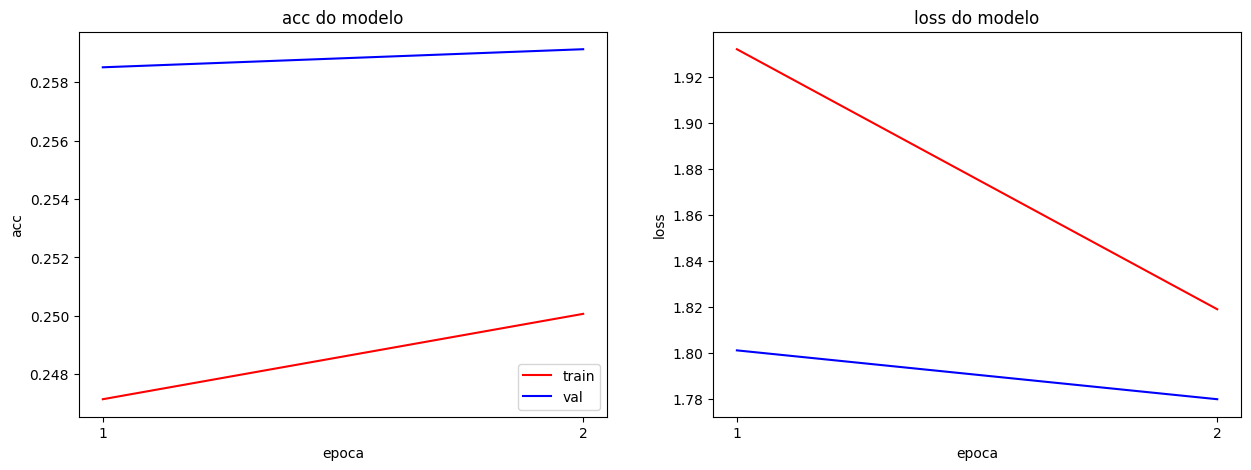

In [25]:
def plot_historico(historico_modelo):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(range(1, len(historico_modelo.history['accuracy']) + 1),
                historico_modelo.history['accuracy'], 'r')

    axs[0].plot(range(1, len(historico_modelo.history['val_accuracy']) + 1),
                historico_modelo.history['val_accuracy'], 'b')

    axs[0].set_title('acc do modelo')
    axs[0].set_ylabel('acc')
    axs[0].set_xlabel('epoca')
    axs[0].set_xticks(np.arange(1, len(historico_modelo.history['accuracy']) + 1,
                  max(1, len(historico_modelo.history['accuracy']) // 10)))

    # -------------------------------------------
    # LOSS
    # -------------------------------------------
    axs[1].plot(range(1, len(historico_modelo.history['loss']) + 1),
                historico_modelo.history['loss'], 'r')

    axs[1].plot(range(1, len(historico_modelo.history['val_loss']) + 1),
                historico_modelo.history['val_loss'], 'b')

    axs[1].set_title('loss do modelo')
    axs[1].set_ylabel('loss')
    axs[1].set_xlabel('epoca')
    axs[1].set_xticks(np.arange(1, len(historico_modelo.history['loss']) + 1,
                  max(1, len(historico_modelo.history['loss']) // 10)))

    axs[0].legend(['train', 'val'], loc='best')

plot_historico(history)

In [26]:
scores = model.evaluate(np.array(x_test), np.array(y_test), batch_size=batch_size)
scores

57/57 [==============================] - 9s 163ms/step - loss: 1.7919 - accuracy: 0.2455


[1.791893720626831, 0.2454722821712494]

In [27]:
print('acc do modelo: ', scores[1] * 100)
print('loss do modelo: ', scores[0])

acc do modelo:  24.54722821712494
loss do modelo:  1.791893720626831
